# Validate operationalization of 'communities'
Natalia Velez, May 2021

In [21]:
%matplotlib inline

import math, json, pymongo, os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')
from utils import int_extract, gsearch

sns.set_style('white')
sns.set_context('talk')

## 1) Spatial proximity

Load lifelogs:

In [41]:
life_df = pd.read_csv('../2_demographics/outputs/all_lifelogs_compact.csv')
print('Before exclusions:')
print(life_df.shape)

life_df = life_df[(np.isfinite(life_df.age)) & (life_df.cause_of_death != 'disconnect')]
print('After exclusions:')
print(life_df.shape)
life_df.head()

Before exclusions:
(3834737, 16)
After exclusions:
(2507311, 16)


,player,avatar,tBirth,parent,birth,sex,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
4,3da17539b16d6fe6911aefc57388bae9d1303e22,4109233,1617695734,4109211,[-16219 -46],M,1.617696e+09,[-16354 -121],2.61,hunger,-16219,-46,-16354.0,-121.0,NaN,NaN
16,a7c23d2f8fbe5e08ed6ca4b42e999bfea32c297d,4109221,1617695102,4109165,[-15496 364],F,1.617695e+09,[-15524 345],5.11,hunger,-15496,364,-15524.0,345.0,NaN,NaN
17,5cbdde910e8de499560018c5d432875a9111e288,4109220,1617695053,4109166,[-15497 362],M,1.617696e+09,[-15595 625],10.58,hunger,-15497,362,-15595.0,625.0,NaN,NaN
20,f713599e2e913dac42bf6a30f5493a6d131ec9aa,4109216,1617694951,4109157,[-16099 360],M,1.617695e+09,[-16083 281],1.43,hunger,-16099,360,-16083.0,281.0,NaN,NaN
23,1d5731ef2943bd073c5f74f7b0ddce88c01ff43d,4109213,1617694903,4109169,[-16099 360],M,1.617695e+09,[-16098 360],0.57,hunger,-16099,360,-16098.0,360.0,NaN,NaN


Load generational data:

In [42]:
def round_down(x):
    return int(math.floor(x / 10.0)) * 10

gen_df = pd.read_csv('../2_demographics/outputs/family_generations.csv')
print('Before exclusions:')
print(gen_df.shape)

# choose families to exclude
n_gens = gen_df.groupby('family')['gen'].agg('max').reset_index()
exclude_families = n_gens[n_gens.gen == 0].family
gen_df = gen_df[~gen_df.family.isin(exclude_families)]
print('After exclusions:')
print(gen_df.shape)

gen_df['gen_bin'] = gen_df.gen.apply(round_down)
gen_df.head()

Before exclusions:
(3834737, 3)
After exclusions:
(3736303, 3)


,family,avatar,gen,gen_bin
1,time-1548814222_eve-3_name-PEPPLER,3,0,0
2,time-1548814222_eve-3_name-PEPPLER,72,1,0
3,time-1548814222_eve-3_name-PEPPLER,38,1,0
4,time-1548814222_eve-3_name-PEPPLER,4,1,0
5,time-1548814227_eve-5_name-ARK,5,0,0


Load spatial proximity data:

In [43]:
dist_df = pd.read_csv('outputs/average_distance.csv')
print(dist_df.shape)
dist_df = dist_df.merge(gen_df, on='avatar')
print(dist_df.shape)
dist_df.head()

(7463982, 4)
(7365566, 7)


,kin,distance,avatar,log_distance,family,gen,gen_bin
0,Non-kin,564.876760,4109237,2.751954,time-1617679935_eve-4108925_name-(missing),10,10
1,Kin,47.957428,4109236,1.680856,time-1617608595_eve-4106600_name-POLLY,53,50
2,Non-kin,473.548778,4109235,2.675365,time-1617679935_eve-4108925_name-(missing),10,10
3,Non-kin,836.942099,4109234,2.922695,time-1617694919_eve-4109214_name-(missing),1,0
4,Kin,191.812908,4109233,2.282878,time-1617684391_eve-4109034_name-(missing),8,0


Count datapoints:

In [45]:
dist_demo = dist_df[['family', 'avatar']].nunique()
dist_demo

family     100190
avatar    3735884
dtype: int64

/n/home15/nvelezalicea/.conda/envs/ohol_py3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gen', ylabel='Density'>

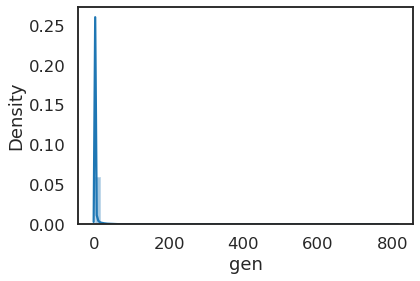

In [48]:
sns.distplot(np.log10(n_gens[n_gens.gen > 0].gen))

Overall spatial proximity:

/n/home15/nvelezalicea/.conda/envs/ohol_py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


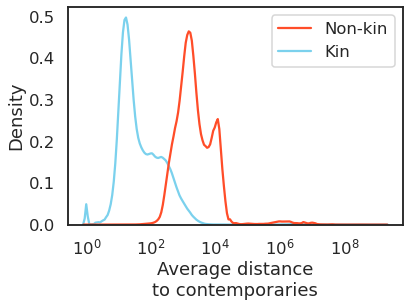

In [44]:
kin_pal = ['#ff4d29', '#7bd1ed']
ax = sns.kdeplot(data=dist_df, x='log_distance', hue='kin', palette = kin_pal)
orig_x = ax.get_xticks()
ax.set(xlabel = 'Average distance\nto contemporaries',
       xticklabels = ['$10^{%i}$' % x_i for x_i in orig_x])
ax.legend_.set_title(None)

In [54]:
dist_summ = dist_df.groupby('kin')['distance'].agg('median').reset_index()
dist_summ['travel_time'] = dist_summ['distance']/3.75/60

dist_summ

,kin,distance,travel_time
0,Kin,30.423990,0.135218
1,Non-kin,1851.329058,8.228129


Change over time:

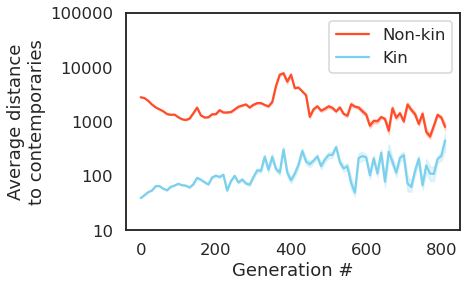

In [52]:
ax = sns.lineplot(x='gen_bin', y='log_distance', hue='kin', 
                  data=dist_df, palette = kin_pal)

ax.set(xlabel = 'Generation #', ylabel = 'Average distance\nto contemporaries',
       yticks = list(range(1,6)),
       yticklabels = [10**y_i for y_i in range(1,6)])
ax.legend_.set_title(None)

/n/home15/nvelezalicea/.conda/envs/ohol_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/home15/nvelezalicea/.conda/envs/ohol_py3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[[<matplotlib.axis.XTick at 0x2b48dc265160>,
 [Text(0, 0, '1'), Text(1, 0, '10'), Text(2, 0, '100'), Text(3, 0, '1000')]]

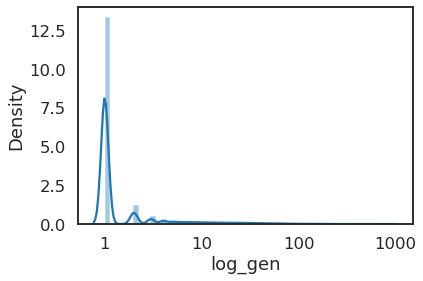

In [112]:
max_gen = n_gens[n_gens.gen > 0]
max_gen['log_gen'] = np.log10(max_gen.gen)
ax = sns.distplot(max_gen.log_gen)
ax.set(xticks = list(range(4)), xticklabels = [10**i for i in range(4)])

In [116]:
max_gen['gen'].agg(['median', 'min', 'max', 'mean'])

median      1.000000
min         1.000000
max       812.000000
mean        3.374567
Name: gen, dtype: float64

## 2) Item interactions

Connect to database:

In [5]:
keyfile = '../6_database/credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['tfidf_matrix.files', 'maplogs', 'item_embeddings', 'tech_tree', 'lifelogs', 'item_links_demo', 'objects', 'expanded_transitions', 'avatar_embeddings', 'tfidf_matrix.chunks', 'transitions', 'activity_matrix.files', 'activity_matrix.chunks', 'cleaned_job_matrix.chunks', 'cleaned_job_matrix.files', 'item_interactions', 'activity_labels', 'categories']


Load linkages:

In [122]:
link_q = db.item_interactions.find({},{'_id': 0, 'target': 1, 'source': 1, 'weight': 1})
link_list = list(link_q)
print(len(link_list))
print(link_list[0])

10399368
{'weight': 4, 'source': 2279719, 'target': 2279890}


Separate out interactions between kin and non-kin:

In [ ]:
fam_df = gen_df[['family', 'avatar']]

# Figure out whether a given directional interaction is between kin or non-kin
link_df = pd.DataFrame(link_list)
link_df = link_df.merge(fam_df, left_on = 'source', right_on = 'avatar')
link_df = link_df.merge(fam_df, left_on = 'target', right_on = 'avatar', suffixes = ('', '_target'))
link_df['kin'] = np.where(link_df['family'] == link_df['family_target'], 'Kin', 'Non-kin')
link_df = link_df[['weight', 'source', 'target', 'kin']]

# Sum over both directions
link_df['min_avatar'] = link_df[['source', 'target']].apply(min, axis=1)
link_df['max_avatar'] = link_df[['source', 'target']].apply(max, axis=1)
link_df['label'] = link_df.apply(lambda row: '%i_%i' %(row.min_avatar, row.max_avatar), axis=1)
link_df = link_df.groupby(['label', 'kin'])['weight'].agg('sum').reset_index()

# Expand out

print(link_df.shape)
link_df.head()

In [ ]:
link_df.groupby('kin')['weight'].agg('sum')

In [121]:
290441/(290441+75394)

0.7939125562070333

Sum over both directions:

In [87]:
link_edges = ["%i %i {'weight': %i}" % (l['source'], l['target'], l['weight']) for l in link_list]
print(link_edges[0])
G = nx.parse_edgelist(link_edges, create_using=nx.MultiGraph)
G_undir = nx.Graph()
G_undir.add_edges_from(G.edges(), weight=0)

for u, v, d in G.edges(data=True):
    G_undir[u][v]['weight'] += d['weight']

2279719 2279890 {'weight': 4}


In [88]:
G_undir